# Delaunay triangulation
## Triangulation

In geometry, <b> triangulation </b> is a partition of a geometric object into simplexes. On a plane, these are triangles.  
Let a geometric object be described by a set of points on the $ S $ plane. Triangulation for a finite set of points $ S $ is the problem of triangulation of the convex hull $ CH (S) $, which covers all points of the set $ S $. Segments of straight lines cannot intersect, but can meet at common points belonging to the set $ S $. We will call these segments <b> edges </b>.
The points can be divided into <b> boundary points </b> - lying on the border of the shell - and <b> internal </b>. Likewise, the edges are divided into <b> shell edges </b> and <b> interior edges </b>.
Each edge of the shell connects two boundary points, and an interior edge connects two points of any type. If an interior edge connects two endpoints, it is <b> chord </b>. Each inner edge is between two triangles, each edge of the shell is between a triangle and an infinite plane.
Except for some trivial cases, any set of points allows more than one triangulation method.

##### The triangulation theorem for a set of points
If the set of points $ S $ contains $ n> 3 $ n collinear points and $ i $ of their inner points, then for any triangulation method $ n + i-2 $ triangles will be obtained.

###### Evidence
$ n-i $ boundary points are the vertices of a convex polygon. Triangulating them will get $ n-i-2 $ triangles.
Next, you need to add $ i $ interior points. There are two options here:
* The point is inside the triangle. In this case, an edge is drawn from each vertex of the triangle to a point, and one triangle is replaced by three. Those. the number of triangles increases by two.
* The point is on the edge. In this case, each triangle adjacent to this edge is divided into two parts. Those. the number of triangles increases by 2 again.

It turns out that by adding all the points, you get $ n-i-2 + 2i = n + i-2 $ triangles

Illustration:

In [24]:
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
import imageio
import io
from math import sqrt, atan2, sin, cos
plt.style.use('dark_background')

[[2.5, 2], [2, 3], [3, 1], [4, 3]]
[[1, 1], [2.5, 2], [3, 1], [4, 3]]
[[1, 1], [2, 3], [2.5, 2], [4, 3]]
[[1, 1], [2, 3], [3, 1], [2.5, 2]]


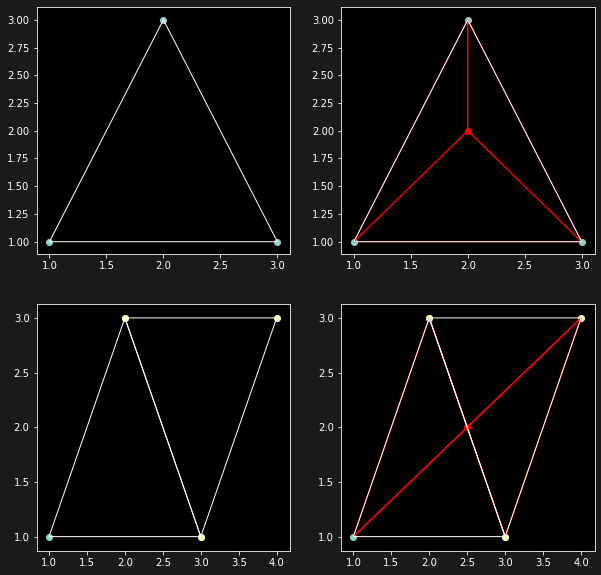

In [25]:
A = [[1,1], [2, 3], [3, 1]]
p1 = [2, 2]
B = [[2, 3], [3, 1], [4, 3]]
p2 = [2.5, 2]

fig, axs = plt.subplots(2,2, figsize=(10,10), facecolor='0.1')
axs[0, 0].scatter([i[0] for i in A], [i[1] for i in A])
axs[0, 0].add_patch(plt.Polygon(A, fill=False))

axs[0, 1].scatter([i[0] for i in A], [i[1] for i in A])
axs[0, 1].scatter(p1[0],p1[1], color='r')
for i in range(3):
    A1 = A[:]
    A1[i] = p1
    axs[0, 1].add_patch(plt.Polygon(A1, fill=False, color='r'))
axs[0, 1].add_patch(plt.Polygon(A, fill=False))

axs[1, 0].scatter([i[0] for i in A], [i[1] for i in A])
axs[1, 0].add_patch(plt.Polygon(A, fill=False))
axs[1, 0].scatter([i[0] for i in B], [i[1] for i in B])
axs[1, 0].add_patch(plt.Polygon(B, fill=False))

axs[1, 1].scatter([i[0] for i in A], [i[1] for i in A])
axs[1, 1].scatter([i[0] for i in B], [i[1] for i in B])
axs[1, 1].scatter(p2[0],p2[1], color='r')

for i in range(4):
    P1 = A[:]+ [B[2]]
    P1[i] = p2
    print(P1)
    axs[1, 1].add_patch(plt.Polygon(P1, fill=False, color='r'))
    
axs[1, 1].add_patch(plt.Polygon(A, fill=False))
axs[1, 1].add_patch(plt.Polygon(B, fill=False))
pass

Let's set a set of points S and define functions for working with a polar coordinate system, as well as a function for comparing angles:

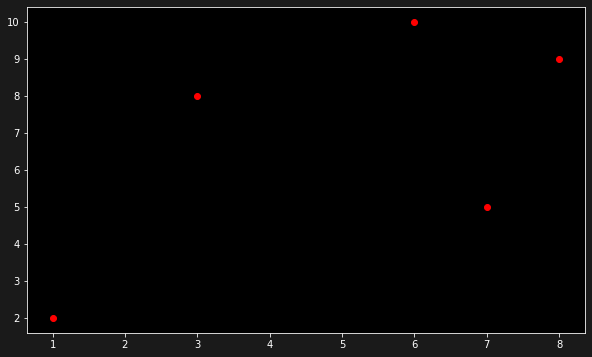

In [26]:
def cart2pol(x, y):
    """Cartesian coordinates to polar"""
    r = sqrt(x**2 + y**2)
    φ = atan2(y, x)
    return(r, φ)

def pol2cart(r, φ):
    """Polar coordinates to Cartesian"""
    x = r * cos(φ)
    y = r * sin(φ)
    return(x, y)

def cmp_angle(φ_1, φ_2):
    """Angle comparison"""
    delta = φ_2 - φ_1
    return delta

def reshuffle_points(points):
    """Shuffling an array from [[x_1, ...], [y_1, ...]] to [[x_1, y_1], ...]"""
    return [[points[0][i], points[1][i]] for i in range(len(points[0]))]

points = [(1,2), (3,8), (6, 10), (7,5), (8,9)]
plt.figure(facecolor='0.1', figsize=(10, 6))
plt.scatter([i[0] for i in points], [i[1] for i in points], color='r')
pass

## Delaunay triangulation algorithm
Let's introduce some new definitions.
* A set of points is <b> circular </b> if there is a circle on which all the points of the set lie. For this set of points, this circle will be circumscribed. For a triangle, this circle will pass through all three of its non-collinear vertices.
* The circle will be <b> free of points </b> if there are no points from the set $ S $ inside the circle.
* Triangulation for a set of points $ S $ - <b> Delaunay triangulation </b> if each circumcircle for each triangle is free of points.

Two conclusions can be drawn from these definitions:
* For triangulation to exist, there must be at least three non-collinear points in the $ S $ set.
* For the Delaunay triangulation to be unique, it is necessary that no 4 points from the set $ S $ lie on the same circumcircle.

The algorithm itself adds one triangle at each step. The triangle connects to the <b> border </b> of the triangulation. In the algorithm step, the edges are classified as follows:
* <b> Sleepers </b> - not yet detected by the algorithm
* <b> Alive </b> - Discovered, but with only one known adjacent area
* <b> Dead </b> - Found with both known contiguous areas.

Thus, <b> border </b> is a collection of living edges. 

##### Algorithm step
At each iteration, any of the edges $ e $ of the boundary is selected. The search is performed for an unknown region to which the edge $ e $ belongs.
If it turns out to be a triangle $ f $, which is defined by the vertices of the edge and some third vertex $ v $, then the edge $ e $ becomes dead. Each of the other two ribs is transferred to the following states - from sleeping to living or from living to dead. The vertex $ v $ is called <b> conjugate </b> with the edge $ e $.
If this area is an infinite plane, the edge is declared dead and has no conjugate vertex.

###### Finding a conjugate edge point
To determine which region the edge $ e $ belongs to, you need to find its conjugate point.
A family of circles passes through the endpoints of each edge. By the definition of Delaunay triangulation, each circumcircle for each triangle must be free of points. Thus, to search for a conjugate point, you need to find such a circle containing the edge points. If the circle does not exist, then the point is adjacent to an infinite plane.

##### Algorithm implementation in Python
First you need to find the first edge. For this we use, for example, one step of the Jarvis algorithm. Those:
1. Take the point with the minimum y-coordinate
2. Take a point with the minimum polar angle and maximum distance

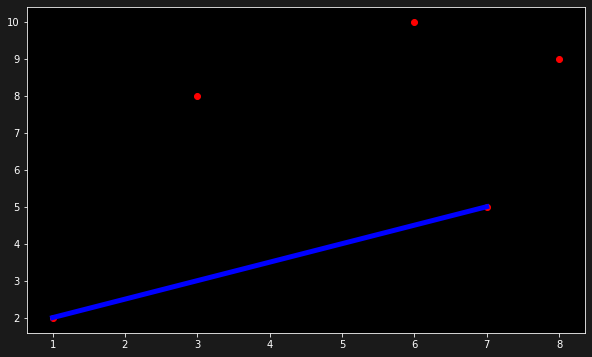

In [27]:
def plot_step(*args, **kwargs):
    """Building an algorithm step"""
    plt.figure(facecolor='0.1', figsize=(10, 6))
    plot_step_ax(plt.gca(), *args, **kwargs)
        
def plot_step_ax(ax, points, frontier, triangles):
    ax.scatter([i[0] for i in points], [i[1] for i in points], color='r')
    for edge in frontier:
        ax.plot([i[0] for i in edge], [i[1] for i in edge], lw=5, color='b')
    for triangle in triangles:
        ax.add_patch(plt.Polygon(triangle, fill=False, color='w'))

def norm(vector):
    t = 0
    for i in vector:
        t = t+i*i
    return sqrt(t)
def hull_edge(points):
    """First rib"""
#     points = reshuffle_points(points)
    p1 = points[0]
    for point in points:
        if point[1] < p1[1]:
            p1 = point
    p2 = points[0]
    min_angle = 3 * 3.14159265
    for point in points:
        if point == p1: continue
        vector = [point[0]-p1[0], point[1]-p1[1] ]
        angle = cart2pol(*vector)[1]
        if angle < min_angle:
            min_angle, p2 = angle, point
        elif angle == min_angle and norm(vector) > norm(p2 - p1):
            p2 = point                
    return [p2, p1]
plot_step(points, [hull_edge(points)], [])

Now let's write a function for getting a circle through three points

In [28]:
# from numpy import linalg
def det(A):
    """
    Create an upper triangle matrix using row operations.
        Then product of diagonal elements is the determinant
        :param A: the matrix to find the determinant for
        :return: the determinant of the matrix
    """
    # Section 1: Establish n parameter and copy A
    n = len(A)
    AM = A[:]

    # Section 2: Row manipulate A into an upper triangle matrix
    for fd in range(n):  # fd stands for focus diagonal
        if AM[fd][fd] == 0:
            AM[fd][fd] = 1.0e-18  # Cheating by adding zero + ~zero
        for i in range(fd+1, n):  # skip row with fd in it.
            crScaler = AM[i][fd] / AM[fd][fd]  # cr stands for "current row".
            for j in range(n):  # cr - crScaler * fdRow, one element at a time.
                AM[i][j] = AM[i][j] - crScaler * AM[fd][j]

    # Section 3: Once AM is in upper triangle form ...
    product = 1.0
    for i in range(n):
        product *= AM[i][i]  # ... product of diagonals is determinant

    return product

def get_circle(a, b, c):
    """Get the coordinates of the center and radius of a circle through three points"""
    vec = [a[0]**2 + a[1]**2, b[0]**2 + b[1]**2, c[0]**2 + c[1]**2]
    x_mat = [vec, [a[1], b[1], c[1]], [1]*3]
    y_mat = [vec, [a[0], b[0], c[0]], [1]*3]
    d_mat = [[a[0], b[0], c[0]], [a[1], b[1], c[1]], [1] * 3]
    d = 2 * det(d_mat)
    x = 1 / d * det(x_mat)
    y = -1 / d * det(y_mat)
    center = [x, y]
#     r = norm(center - a)
    r = norm([center[0]-a[0], center[1]-a[1]])
    return center, r

def get_circle_coords(center, r):
    """Construct a circle by radius and center"""
    circle = [[r, 180* phi/3.14159265] for phi in range(0, 180, 5)]
    circle = [pol2cart(p[0], p[1]) + (center[0], center[1]) for p in circle]
    return circle

def orientIfSure(px, py, rx, ry, qx, qy):
    l = (ry - py) * (qx - px)
    r = (rx - px) * (qy - py)

    if (abs(l - r) >= 3.3306690738754716e-16 * abs(l + r)):
        return l - r
    else:
        return 0

# a more robust orientation test that's stable in a given triangle (to fix robustness issues)
def orient(rx, ry, qx, qy, px, py):
    return (orientIfSure(px, py, rx, ry, qx, qy) or\
        orientIfSure(rx, ry, qx, qy, px, py) or\
        orientIfSure(qx, qy, px, py, rx, ry)) < 0


def same_side(edge, p1, p2):
    """Check if points p1 and p2 are on the same side of edge"""
    x1, y1 = edge[0][0], edge[0][1]
    x2, y2 = edge[1][0], edge[1][1]
    ax, ay = p1[0], p1[1]
    bx, by = p2[0], p2[1]
#     print(f"edge: {x1,y1, x2, y2}")
#     print(f"points: {ax, ay, bx, by}")
#     m = y2 - y1/(x2-x1)
#     c = y1 - x1*m
#     eq1 = ax - ay/m + c/m
#     eq2 = bx - by/m + c/m
#     return eq1*eq2 < 0

    return orient(x1,y1, x2, y2, ax, ay) == orient(x1,y1, x2, y2, bx, by)

#     edge_vec = [edge[1][0] - edge[0][0], edge[1][1] - edge[0][1]]
#     p1_vec, p2_vec = [p1[0] - edge[0][0], p1[1] - edge[0][1]], [p2[0] - edge[0][0], p2[1] - edge[0][1]]
#     edge_angle = cart2pol(edge_vec[0], edge_vec[1])[1]
#     p1_angle, p2_angle = cart2pol(p1_vec[0], p1_vec[1])[1], cart2pol(p2_vec[0], p2_vec[1])[1]
#     p1_delta, p2_delta = cmp_angle(edge_angle, p1_angle), cmp_angle(edge_angle, p2_angle)
#     return p1_delta * p2_delta > 0

def get_distance(edge, center, r, candidate):
    """Distance from an edge to the other end of the circle.
     candidate indicates which side to read from"""
    p1, p2, p0 = edge[0], edge[1], center
    edge_len = norm([p2[0] - p1[0], p2[1] - p1[1]])
    sq = abs((p2[1]-p1[1])*p0[0] - (p2[0]-p1[0])*p0[1] + p2[0]*p1[1] - p2[1]*p1[0])
    dist = sq / edge_len
    if same_side(edge, center, candidate):
        return r + dist
    else:
        return r - dist

A new function can illustrate finding a mating point for an edge

In [29]:
p1 = (4,1)
p2 = (2,2)
edge = [(3, 0), (0, 3)]
print(same_side(edge, p1, p2))

p1 = (1,2)
p2 = (8, 9)
# (8, 9) in none or same side as (1, 2)
edge = [(7, 5), (3, 8)]
print(same_side(edge, p1, p2))

True
False


Accordingly, if the circle does not exist, the edge is adjacent to the infinite plane.

For the present algorithm, it is more rational to iterate over all points and find the minimal circle (with the smallest distance from the middle of the edge to a point on the circle) than to check the entire infinite family of circles.

If the edge already has a conjugate point, then it is necessary to exclude from the enumeration all other points that lie on the same side with respect to the edge as the conjugate.

[(7, 5), (1, 2)]
for edge: [(7, 5), (1, 2)]
ptsList: [(1, 2), (3, 8), (6, 10), (7, 5), (8, 9)]
 third point:None
working on point: (1, 2)
exiting because point in arr: 1
working on point: (3, 8)
  point: (3, 8)
  center: [3.499999999999999, 4.499999999999999]
   dist: 4.653567894682633
working on point: (6, 10)
  point: (6, 10)
  center: [2.4090909090909087, 6.68181818181818]
   dist: 8.446650622213248
working on point: (7, 5)
exiting because point in arr: 0
working on point: (8, 9)
  point: (8, 9)
  center: [1.4999999999999991, 8.5]
   dist: 12.109372348952125
best : (3, 8)


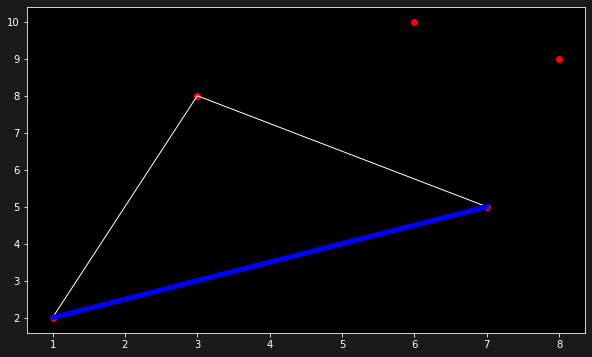

In [30]:
# This stuff is definitely overcomplicated
def point_in_arr(arr, point):
    """Are there points in the array"""
    for i in range(len(arr)):
        if arr[i][0] == point[0] and arr[i][1] == point[1]:
            return i
    return -1

def get_third_point(edge, triangles):
    """Get conjugate point for an edge from known triangles"""
    for triangle in triangles:
        i1, i2 = point_in_arr(triangle, edge[0]), point_in_arr(triangle, edge[1])
        if not (i1 == -1 or i2 == -1):
            for i in range(len(triangle)):
                if not (i1 == i or i2 == i):
                    return triangle[i]
    return None    

def get_mate(edge, points, triangles):
    """Get a new mating point"""
    best_point, best_dist = None, None
#     points = reshuffle_points(points)
    third = get_third_point(edge, triangles)
    print(f"for edge: {edge}")
    print(f"ptsList: {points}")
    print(f" third point:{third}")
    for point in points:
        print(f"working on point: {point}")
        if point_in_arr(edge, point) > -1:
            print(f"exiting because point in arr: {point_in_arr(edge, point)}")
            continue
        if third is not None and same_side(edge, point, third):
            print(f"exiting: {point} in none or same side as {third}")
            continue
        center, r = get_circle(edge[0], edge[1], point)
        dist = get_distance(edge, center, r, point)
        print(f"  point: {point}\n  center: {center}\n   dist: {dist}")
        if best_point is None or dist < best_dist:
            best_point, best_dist = point, dist
    print(f"best : {best_point}")
    return best_point

frontier = [hull_edge(points)]
print(frontier[0])
mate = get_mate(frontier[0], points, [])
triangles = [[frontier[0][0], frontier[0][1], mate]]
plot_step(points, frontier, triangles)


After finding the point, the task is to update the border. The two resulting edges should be added to the border and the used one removed.

[[(7, 5), (1, 2)]]
[[(7, 5), (3, 8)], [(1, 2), (3, 8)]]
for edge: [(7, 5), (3, 8)]
ptsList: [(1, 2), (3, 8), (6, 10), (7, 5), (8, 9)]
 third point:(1, 2)
working on point: (1, 2)
exiting: (1, 2) in none or same side as (1, 2)
working on point: (3, 8)
exiting because point in arr: 1
working on point: (6, 10)
  point: (6, 10)
  center: [5.617647058823532, 7.32352941176471]
   dist: 3.7330553398309236
working on point: (7, 5)
exiting because point in arr: 0
working on point: (8, 9)
  point: (8, 9)
  center: [5.710526315789476, 7.447368421052636]
   dist: 3.9504994791616714
best : (6, 10)
(6, 10)


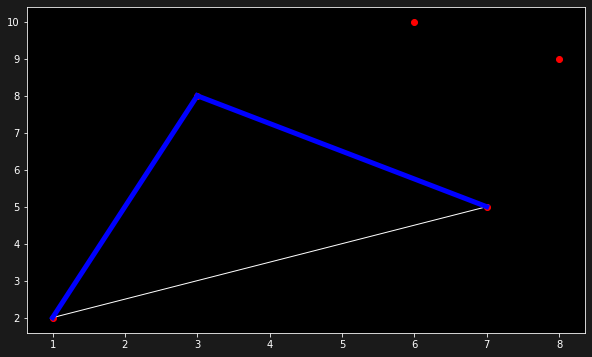

In [31]:
def edge_in_frontier(frontier, edge):
    """Is there a rib in the border"""
    if len(frontier) == 0:
        return None
    for frontier_edge in frontier:
        if frontier_edge == edge:
            return frontier_edge
        flipped = [frontier_edge[1], frontier_edge[0]]
        if flipped == edge:
            return frontier_edge
    return None

def remove_edge_from_frontier(frontier, edge):
    """Remove edge from boundary"""
    for i in range(len(frontier)):
        if frontier[i] == edge:
            frontier.remove(edge)
            break
    return frontier

def update_frontier(frontier, point, used_edge):
    """Refresh border"""
    edge1 = [used_edge[0], point]
    edge2 = [used_edge[1], point]
    used_edge = edge_in_frontier(frontier, used_edge)
    fr_edge1 = edge_in_frontier(frontier, edge1)
    fr_edge2 = edge_in_frontier(frontier, edge2)
    if used_edge is not None:
        frontier = remove_edge_from_frontier(frontier, used_edge)
    if fr_edge1 is not None:
        frontier = remove_edge_from_frontier(frontier, fr_edge1)
    else:
        frontier.append(edge1)
    if fr_edge2 is not None:
        frontier = remove_edge_from_frontier(frontier, fr_edge2)
    else:
#         frontier = np.append(frontier, np.array([edge2]), axis=0)
        frontier.append(edge2)
    return frontier
print(frontier)
frontier = update_frontier(frontier, mate, frontier[0])
print(frontier)

mate = get_mate(frontier[0], points, triangles)
print(mate)


plot_step(points, frontier, triangles)

Now you can implement the triangulation algorithm itself. Let's execute it step by step

for edge: [(7, 5), (1, 2)]
ptsList: [(1, 2), (3, 8), (6, 10), (7, 5), (8, 9)]
 third point:None
working on point: (1, 2)
exiting because point in arr: 1
working on point: (3, 8)
  point: (3, 8)
  center: [3.499999999999999, 4.499999999999999]
   dist: 4.653567894682633
working on point: (6, 10)
  point: (6, 10)
  center: [2.4090909090909087, 6.68181818181818]
   dist: 8.446650622213248
working on point: (7, 5)
exiting because point in arr: 0
working on point: (8, 9)
  point: (8, 9)
  center: [1.4999999999999991, 8.5]
   dist: 12.109372348952125
best : (3, 8)


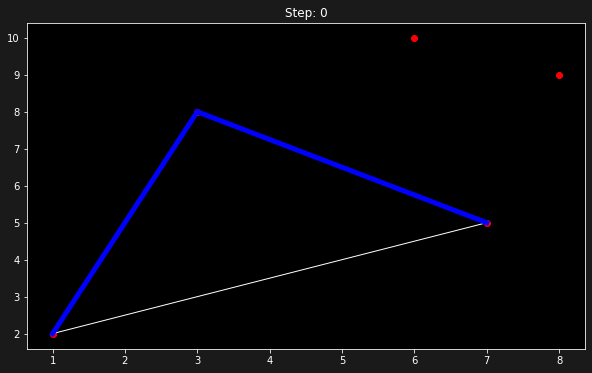

for edge: [(1, 2), (3, 8)]
ptsList: [(1, 2), (3, 8), (6, 10), (7, 5), (8, 9)]
 third point:(7, 5)
working on point: (1, 2)
exiting because point in arr: 0
working on point: (3, 8)
exiting because point in arr: 1
working on point: (6, 10)
exiting: (6, 10) in none or same side as (7, 5)
working on point: (7, 5)
exiting: (7, 5) in none or same side as (7, 5)
working on point: (8, 9)
exiting: (8, 9) in none or same side as (7, 5)
best : None


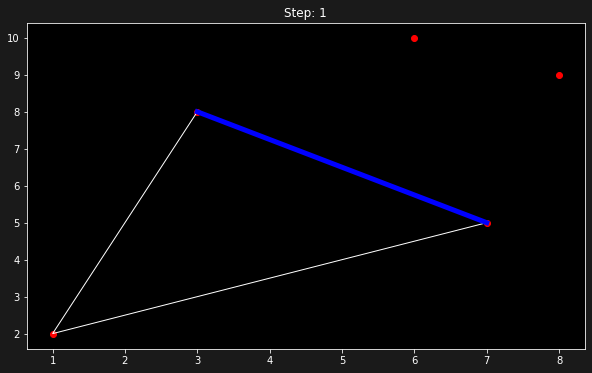

for edge: [(7, 5), (3, 8)]
ptsList: [(1, 2), (3, 8), (6, 10), (7, 5), (8, 9)]
 third point:(1, 2)
working on point: (1, 2)
exiting: (1, 2) in none or same side as (1, 2)
working on point: (3, 8)
exiting because point in arr: 1
working on point: (6, 10)
  point: (6, 10)
  center: [5.617647058823532, 7.32352941176471]
   dist: 3.7330553398309236
working on point: (7, 5)
exiting because point in arr: 0
working on point: (8, 9)
  point: (8, 9)
  center: [5.710526315789476, 7.447368421052636]
   dist: 3.9504994791616714
best : (6, 10)


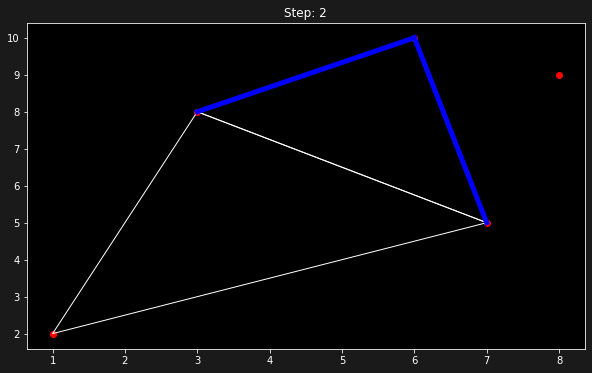

for edge: [(3, 8), (6, 10)]
ptsList: [(1, 2), (3, 8), (6, 10), (7, 5), (8, 9)]
 third point:(7, 5)
working on point: (1, 2)
exiting: (1, 2) in none or same side as (7, 5)
working on point: (3, 8)
exiting because point in arr: 0
working on point: (6, 10)
exiting because point in arr: 1
working on point: (7, 5)
exiting: (7, 5) in none or same side as (7, 5)
working on point: (8, 9)
exiting: (8, 9) in none or same side as (7, 5)
best : None


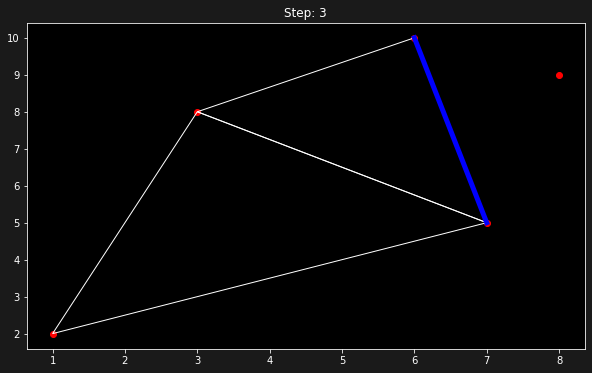

for edge: [(7, 5), (6, 10)]
ptsList: [(1, 2), (3, 8), (6, 10), (7, 5), (8, 9)]
 third point:(3, 8)
working on point: (1, 2)
exiting: (1, 2) in none or same side as (3, 8)
working on point: (3, 8)
exiting: (3, 8) in none or same side as (3, 8)
working on point: (6, 10)
exiting because point in arr: 1
working on point: (7, 5)
exiting because point in arr: 0
working on point: (8, 9)
  point: (8, 9)
  center: [5.944444444444447, 7.388888888888886]
   dist: 2.0451443370548334
best : (8, 9)


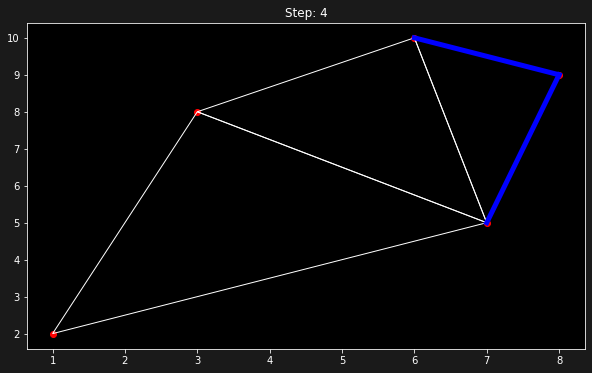

for edge: [(6, 10), (8, 9)]
ptsList: [(1, 2), (3, 8), (6, 10), (7, 5), (8, 9)]
 third point:(7, 5)
working on point: (1, 2)
exiting: (1, 2) in none or same side as (7, 5)
working on point: (3, 8)
exiting: (3, 8) in none or same side as (7, 5)
working on point: (6, 10)
exiting because point in arr: 0
working on point: (7, 5)
exiting: (7, 5) in none or same side as (7, 5)
working on point: (8, 9)
exiting because point in arr: 1
best : None


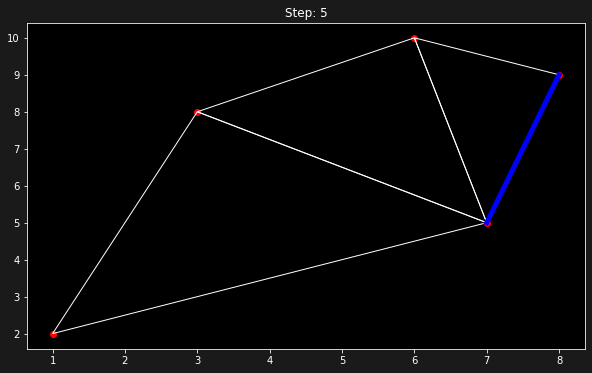

for edge: [(7, 5), (8, 9)]
ptsList: [(1, 2), (3, 8), (6, 10), (7, 5), (8, 9)]
 third point:(6, 10)
working on point: (1, 2)
exiting: (1, 2) in none or same side as (6, 10)
working on point: (3, 8)
exiting: (3, 8) in none or same side as (6, 10)
working on point: (6, 10)
exiting: (6, 10) in none or same side as (6, 10)
working on point: (7, 5)
exiting because point in arr: 0
working on point: (8, 9)
exiting because point in arr: 1
best : None


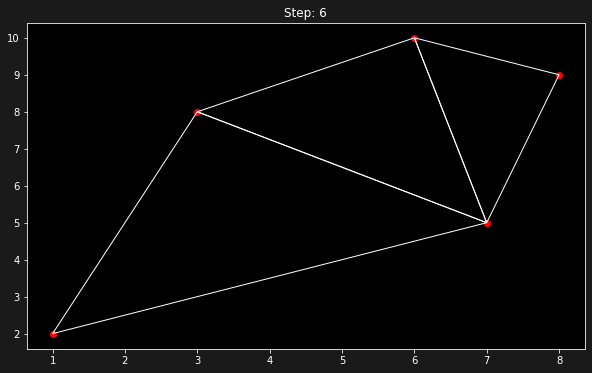

In [32]:
def one_step(points, triangles, frontier):
    edge, frontier = frontier[-1], frontier[:-1]
    mate = get_mate(edge, points, triangles)
    if mate is not None:
        frontier = update_frontier(frontier, mate, edge)
        triangle = [edge[0], edge[1], mate]
        triangles.append(triangle)
    return frontier, triangles
    
def init_delanay(points):
    triangles = []
    frontier = [hull_edge(points)]
    return triangles, frontier

    
triangles, frontier = init_delanay(points)    

for cnt in range(10):
    frontier, triangles = one_step(points, triangles, frontier)
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='0.1')
    plot_step_ax(ax, points, frontier, triangles)
    plt.title(f"Step: {cnt}")
    if len(frontier) == 0:
        break
    plt.show()

pass

To achieve a similar result, you can use the triangulation module in matplotlib. You can make sure that all circles built around triangles are free of points

In [ ]:
from matplotlib import tri

def delanay_mpl(points, circles=True):
    tr = tri.Triangulation(points[0], points[1])
    plt.figure(facecolor='0.1', figsize=(10, 10))
    plt.scatter(*points, color='r')
    plt.gca().triplot(tr, color='y')
    if not circles:
        return
    plt.xlim((0, 10))
    plt.ylim((0, 10))
    for triangle in tr.triangles:
        A = np.array([
            [points[0][triangle[i]], points[1][triangle[i]]]
            for i in range(3)
        ])
        circle = get_circle_coords(*get_circle(*A))
        plt.gca().plot(circle[:, 0], circle[:, 1], color='r')
    
delanay_mpl(points, circles=True)

Let's test the algorithm on more points

In [ ]:
def delanay(points, cnt=2**16):
    triangles = []
    frontier = np.array([hull_edge(points)])
    while len(frontier) > 0 and cnt > 0:
        cnt -= 1
        frontier, triangles = one_step(points, triangles, frontier)
    return frontier, triangles

points = np.random.rand(2, 100) * 100
frontier, triangles = delanay(points)
plot_step(points, frontier, triangles)

## Animation

In [ ]:
points = np.random.rand(2, 200) * 100
cnt = 0

fig, ax = plt.subplots(figsize=(24, 14), facecolor='0.1')

bar = tqdm()
triangles, frontier = init_delanay(points)

with imageio.get_writer('./_res.mp4', mode='I', fps=30, quality=7) as writer:
    while True:
        ax.cla()
        frontier, triangles = one_step(points, triangles, frontier)
        plot_step_ax(ax, points, frontier, triangles)
        
        cnt += 1
        bar.set_description(f"Step: {cnt}, Frontier length: {len(frontier)}")
        ax.set_title(f'Delanay triangulation. Step: {cnt}', fontsize=24)
        bar.update(1)
        
        if len(frontier) == 0 and cnt > 10:
            break
            
        with io.BytesIO() as buf:
            plt.savefig(buf, format='png')
            buf.seek(0)
            writer.append_data(imageio.imread(buf))
    
    bar.close()
    
    for i in trange(60):
        with io.BytesIO() as buf:
            plt.savefig(buf, format='png')
            buf.seek(0)
            writer.append_data(imageio.imread(buf))
            